# Kaggle Competition 1

# Table of contents
1. [Purpose of Participating](#PurposeofParticipating)
2. [Competition Information](#CompetitionOfPart)
    1. [Why CNN](#WhyCNN)
      1. [Sparse Interaction](#SparseInteraction)
      2. [Parameter Sharing](#ParameterSharing)
      3. [Equivarent Representation](#EquivarentRepresentation)
3. [Project Outline](#ProjectOutline)
    1. [Data Management](#DataManagement)
    2. [Model Formulation](#ModelFormulation)
    3. [Analyze Model Output](#ModelOutput)
4. [Data Analysis](#DataAnalysis)
    1. [Reproducibility](#Reproducibility)
    2. [Loading Data](#LoadData)
    3. [Data Exploration](#DataExploration)
    4. [Data Visualization](#DataVisualization)
    5. [Data Manipulation](#DataManipulation)
    6. [Data Augmentation](#DataAugmentation)
    7. [Defining the Model](#DefinetheModel)
5. [Model Results/Predictions](#Results)
    1. [Model Results](#ModelResults)
    2. [Model Predictions](#ModelPredictions)
    3. [Post Processing Model Results](#PostProcessingModelResults)
    4. [Predicting the Testing Data](#PredictingtheTestingData)
6. [Prepare Submission](#PrepareSubmission)
      

## Purpose of Participating <a name="PurposeofParticipating"></a>
This is the first kaggle competition I particpated in. The reason for doing this is to:
1. learn how to use Keras
2. understand convolutional networks
3. apply knowledge to a real world problem
4. improve programming ability with python

## Competition Information <a name="CompetitionOfPart"></a>
This goal of this Kaggle competition is to identify if salt is present in an image at the pixel by pixel level. Training data included sesmic images of dimension 101x101 along with the mask, the location of true data, taken at a given depth. Below are examples of the salt image and its corresponding salt mask. The depth of the semsic image is defined to be the center of the image. Validation data included sesmic images with depth. 

![salt image](image2.png "salt_image")
![salt mask](mask2.png "salt_mask")


In the context of machine learning this is an image segmentation problem that is best analyzed using convolution neural networks because of the grid like topology of the data; i.e. images. Convolutional networks are better suited for image analysis over a neural network because of sparse interaction between layers, sharing parameters for more than one function, and lastly equivarent representation. We will briefly cover these three items below.

### Why CNN <a name="WhyCNN"></a>

### Sparse Interaction <a name="SparseInteraction"></a>
If traditional neural network are used for image processing it would be computationally expensive because of their use of matrix multiplication of parameters to describe the interaction between every input and every output. However using kernels, a multidimensional array of parameters for feature detection, the number of parameters interacting between the input and output can be reduced. For example if there are n input by m output then the computation time is $O(mxn)$, whereas if the number of connection is reduced to k then it requires computing of $O(kxn)$. 

### Parameter sharing <a name="ParameterSharing"></a>
Parameter sharing doesn't help reduce the run time, however it helps reduce the data storage requirements. This is done by limiting the number of parameters shared between each input and output layer, which in a typical neural net can be large for image processing.  

### Equivarent Representation <a name="EquivarentRepresentation"></a>
Equivarent representation is important because it means a classifier can classify a distorted image $I'$ from $I$. If image pixels are translated from $(a,b) \to (a-v,b-u) $ then for instance the maximum values of the image $I$ will vary equally with the distortion in image $I'$.

# Project Outline <a name="ProjectOutline"></a>
This project can be broken down into three parts.

1. Data management 
2. Model formulation
3. Analyze model output

## Data Management <a name="DataManagement"></a>
The input data consists of 4000 training data images with their respective masks with dimensions 101x101. The masks contain the information of where the salt is located for each image. Additional information that was included but not used in this analysis was the depth of each image. No particular efforts were made to reduce data overhead for this project as it was possible to load all training images and masks into memory without issues. The training data was split between 90% was for training and 10% for validation.

To provide more training data to the models, the data was augmented using Keras's methods that distorted the image during the training of the model. 

## Model formulation <a name="ModelFormulation"></a>

#### Block structure
Convolutional neural networks consist of a convolution layer that include a pooling, detector, and convolution stage. Together these make a convolution block. In the final version of this code the convolution block was made up of a 2D convolutional layer, batch normalization, 2D convolutional layer, batch normalization, followed lastly by a max pooling layer.

Max pooling takes the output of a layer and reduces the image size by the pooling factor $p$ by taking the maximum pixel value and assigning the new image this value. For instance is the pooling size is 2, then an image will go from size 32 to 16. One unique feature of max pooling over spatial regions is that it introduces invariance to translation in the model. 

Batch normalization (BN) will normalize the input layers by adjusting and scaling the activation layers. The benefit of BN is that is speeds up the learning time by limiting the range over which the parameters at each layer can shift. It also helps in reducing overfitting by adding noise to each hidden layer's acitivation functions. 

The 2D convolution layers are responsible for creating a convolution kernel that is convolved with the input layer, in this case the size of the kernel was chosen to be $3x3$.  The strides for the 2D convolution layer defines the number of pixels the kernel is moved as it scans over the iamge. If the stride is equal to one, as it is in this analysis, then when the "same" padding is used this results in hte size of the output are the same as the input.  An exponential linear unit acitivation function was used at each layer, the functional form of this is $a*e^{x}-1$ for $x <0$ and $x$ for $x>0$

#### Architecture

As mentioned earlier a U-net convolutional neural net architecture is used. The blocks were structured together under the U-net model, this model has two parts: a down sampling block structure and a symmetric upsampling structure. Downsampling reduces the image size while also extracting important features for classifying the image, and the symmetric upsampling part allows for localization of features in the image. This therefore makes the U-net an ideal model structure to extract important features of the sesmic image that allude to the presence of salt but also the relative location of salt within the image.

![unet](unet.png "U-Net architecture")


source: Deeply-Supervised CNN for Prostate Segmentation by Zhu, Qikui et al.
#### Loss Functions

Apart from choosing the structure of the convolution block, an appropriate loss function to train the model must be used. At first the binary cross entropy loss function was used because for each pixel element within an image is either salt or not salt. The function form of the binary cross entropy loss function is as follows: 

$ L_{BCE} = -\frac{1}{N} \sum^{N}_{n=1} \{y_{n} log(\hat{y}_n + (1-y_{n})log(1-\hat{y}_n) \} $ 

which is a measure of how well the model with its weights are predicting the true value. 

To complement the binary cross entropy loss function in this analysis another loss function is commonly used in image segmentation problems, the [DICE loss](https://github.com/pytorch/pytorch/issues/1249). The DICE loss measures the overlap of the predicted values from the model with the true values provided from the masks. To prevent the function from diverging a small factor $\epsilon$ is added to the numerator. The forumla for the DICE loss is

$ L_{DICE} = \frac{ \sum^{N}_{n=1} p_{n}t_{n} }{p_{n} + t_{n} + \epsilon} $ 

where $ p_{n} $ and $t_{n} $, are the predicted and true values respectively. 

### Analyze Model Output <a name="ModelOutput"></a>
This stage of the analysis is important to determine the performance of the model for making decisions to tweak the model.


# Part 1: Data Analysis <a name="DataAnalysis"></a>

### Reproducibility <a name="Reproducibility"></a>
Final results from this anaylsis are dependent on the starting point of the weights in the convolution kernels. To aim for reproducable results for testing the code and looking for improvements, the seed for the random generator in TensorFlow, which is called by Keras, can be controlled with the following code below. 

In [1]:
import os
import sys
import cv2
import numpy as np
import tensorflow as tf
import random as rn
os.environ['PYTHONHASHSEED'] = '0'

from keras import backend as K

np.random.seed(27)
rn.seed(27)
tf.set_random_seed(27)

/home/kuantumlad/.local/lib/python2.7/site-packages/h5py/__init__.py:36: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._conv import register_converters as _register_converters
/home/kuantumlad/.local/lib/python2.7/site-packages/h5py/__init__.py:45: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from . import h5a, h5d, h5ds, h5f, h5fd, h5g, h5r, h5s, h5t, h5p, h5z
/home/kuantumlad/.local/lib/python2.7/site-packages/h5py/_hl/group.py:22: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .. import h5g, h5i, h5o, h5r, h5t, h5l, h5p
/home/kuantumlad/.local/lib/python2.7/site-packages/scipy/sparse/lil.py:19: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from . import _csparsetools
/home/kuantumlad/.local/lib/python2.7/site-packages/scipy/sparse/csgraph/__init__.py:165: 

In [2]:
import pandas as pd
import math
import matplotlib.pyplot as plt
from skimage.transform import resize
%matplotlib inline
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set_style("white")

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label, erosion, dilation
from skimage.morphology import disk

import keras
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Lambda, Activation
from keras.layers.convolutional import Conv2D, Conv2DTranspose, UpSampling2D
from keras.layers import BatchNormalization
from keras.layers import Dropout, SpatialDropout2D
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
from keras.optimizers import SGD
import keras.applications
from keras.losses import binary_crossentropy
from keras.preprocessing import image
from keras import optimizers


from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img




/home/kuantumlad/.local/lib/python2.7/site-packages/scipy/signal/_max_len_seq.py:8: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._max_len_seq_inner import _max_len_seq_inner
/home/kuantumlad/.local/lib/python2.7/site-packages/scipy/signal/_upfirdn.py:36: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._upfirdn_apply import _output_len, _apply
/home/kuantumlad/.local/lib/python2.7/site-packages/scipy/optimize/_trlib/__init__.py:1: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._trlib import TRLIBQuadraticSubproblem
/home/kuantumlad/.local/lib/python2.7/site-packages/scipy/optimize/_numdiff.py:10: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._group_columns import group_dense, group_sparse
/home/kuantumlad/.local/lib/python2.7/site-packages/scipy/sig

# Loading Data <a name="LoadData"></a>
Specify the testing and training image paths.

In [3]:
# set path relative to current directory
os.path.join(os.path.curdir, 'input/')
ABS_INPUT_PATH = os.path.join(os.path.curdir, 'input/') 
BAD_MASKS_PATH = "/home/kuantumlad/Documents/projects/kaggle/kaggle-tgs_salt/input/train/bad_masks/bad_masks.txt"
TEST_PATH = 'test/'
TRAIN_PATH = 'train/'
MASKS_PATH = 'masks/'
IMAGES_PATH = 'images/'
DEPTH_PATH = ABS_INPUT_PATH + TRAIN_PATH + 'depths.csv'
IMAGE_PROPERTIES = (128,128,1)
ORIGINAL_IMG_PROPERTIES = (101,101,1)

In [4]:
training_data = "/home/kuantumlad/Documents/projects/kaggle/kaggle-tgs_salt/input/train/training_id.txt"
depth_data = "/home/kuantumlad/Documents/projects/kaggle/kaggle-tgs_salt/input/depths.csv"
train_df = pd.read_csv(training_data, index_col="id", usecols=[0])
depths_df = pd.read_csv(depth_data, index_col="id")
train_df = train_df.join(depths_df)
test_df = depths_df[~depths_df.index.isin(train_df.index)]

In [5]:
train_df["images"] = [np.array(load_img("/home/kuantumlad/Documents/projects/kaggle/kaggle-tgs_salt/input/train/images/{}.png".format(idx), color_mode="grayscale")) for idx in tqdm_notebook(train_df.index)]


In [6]:
train_df["masks"] = [np.array(load_img("/home/kuantumlad/Documents/projects/kaggle/kaggle-tgs_salt/input/train/masks/{}.png".format(idx),color_mode="grayscale"))/255 for idx in tqdm_notebook(train_df.index)]


## Data Exploration <a name="DataExploration"></a>
Here we look at the percent of salt coverage per mask to determine if the training and validation data need to mirror the true distribution of data and bin it into 20 bins. After that the sesmic images and masks are displayed as a quality check on the data.

In [7]:
def bin_coverage(val):
    for i in range(0,21):
        if val * 20 <= i:
            return i

In [8]:
train_df["coverage"] = train_df.masks.map(np.sum) / pow(ORIGINAL_IMG_PROPERTIES[0], 2)
train_df["coverage_class"] = train_df.coverage.map(bin_coverage)

Text(0.5,0,'Coverage class')

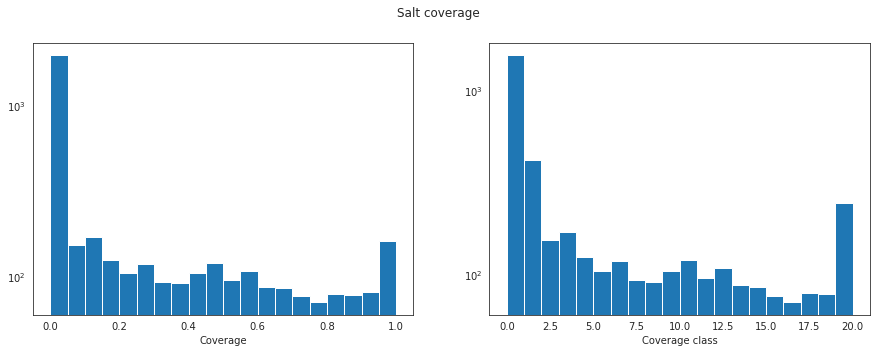

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
axs[0].hist(train_df.coverage, bins=20)
axs[0].set_yscale('log')
axs[1].hist(train_df.coverage_class, bins=20)
axs[1].set_yscale('log')
plt.suptitle("Salt coverage")
axs[0].set_xlabel("Coverage")
axs[1].set_xlabel("Coverage class")

# Data Visualization <a name="DataVisualization"></a>
Below are examples of the images and masks that are used to train the convolutional neural network.

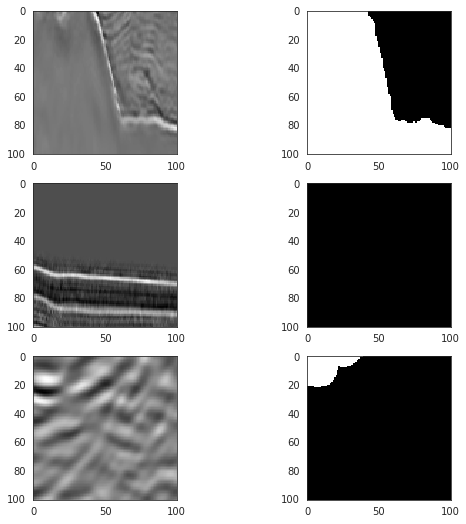

In [10]:
img_names = train_df.index[10:16]
img = train_df.loc[img_names[5]].images
mask = train_df.loc[img_names[5]].masks
    
fig, axs = plt.subplots(3,2,figsize=(9,9))
k = 0
for i in range(3):
    img = train_df.loc[img_names[k]].images
    mask = train_df.loc[img_names[k]].masks
    axs[i,0].imshow(img,cmap='gray')
    axs[i,1].imshow(mask,cmap='gray')
    k=k+1

## Data Manipulation <a name="DataManipulation"></a>
The training data original size is 101x101, while possible to use within the CNN by adjusting the padding at each layer or the steps, the data was instead padded with empty space so that the image size was 128x128. The images are downscaled before final scoring.

In [11]:
def downscale(input_image, resized_shape=(101,101,1)):
    height, width, channels = input_image.shape
    h_start = (height - resized_shape[0]) // 2
    w_start = (width - resized_shape[1]) // 2
    return input_image[h_start:resized_shape[0]+h_start, w_start:resized_shape[1]+w_start, :]


def upscale(input_image, resized_shape=(128,128,1)):
    new_image = np.zeros(shape=resized_shape)
    height = input_image.shape[0]
    width = input_image.shape[1]
    h_start = (resized_shape[0] - height) // 2
    w_start = (resized_shape[1] - width) // 2
    new_image[h_start:height+h_start, w_start:width+w_start,0] = input_image
    
    return new_image

In [12]:
ids_train, ids_val, x_train, x_val, y_train, y_val, cov_train, cov_test = train_test_split(
    train_df.index.values,
    np.array(train_df.images.map(upscale).tolist()),#.reshape(-1, 128,128, 1), # COMMENT OUT WILL ITHELP??? 
    np.array(train_df.masks.map(upscale).tolist()),#.reshape(-1, 128,128, 1), 
    train_df.coverage.values,
    test_size=0.2, stratify=train_df.coverage_class, random_state=1337)

### Data check
Check that the padding worked as expected

In [13]:
tmp_img = np.zeros( (101, 101), dtype=train_df.images.loc[ids_train[2]].dtype)
tmp_img[:128, :128] = train_df.images.loc[ids_train[10]]

tmp_upscale = np.zeros( ( 128,128), dtype=train_df.images.loc[ids_train[2]].dtype)
tmp_upscale[:128,:128] = x_train[10].squeeze()

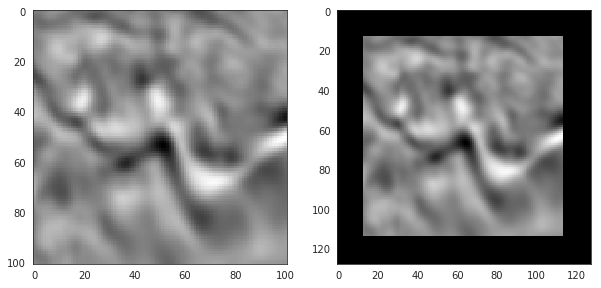

In [14]:
fig3, axs3 = plt.subplots(1,2, figsize=(10,10))
axs3[0].imshow(tmp_img,cmap='gray')
axs3[1].imshow(tmp_upscale, cmap='gray')

## Data Augmentation  <a name="DataAugmentation"></a>
Data augmentation can be a powerful tool when developing a suitable model. It provides a way of getting 'more' data without actually getting more data by applying shifts or rotations to the data image. 

Below are a few examples of data augmentation used in this analysis. 

In [15]:
#AUG DATA
x_train2 = x_train
y_train2 = y_train
x_train2 = np.append(x_train, [np.fliplr(x) for x in x_train], axis=0)
y_train2 = np.append(y_train, [np.fliplr(x) for x in y_train], axis=0)

### Horizontal Flips
One example of data augmentation used here was a left-right flip of the image. Up-down flips were not used in this analysis because an augmentation of that nature does not preserve the physics contained in the image. If the sesmicgraph is able to capture physical information due to the force of gravity on the system, then that would be lost. 

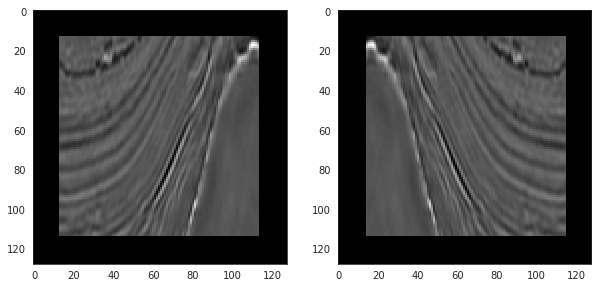

In [35]:
fig4, axs4 = plt.subplots(1,2, figsize=(10,10))
tmp_og = np.zeros( (128, 128), dtype=train_df.images.loc[ids_train[2]].dtype)
tmp_og[:128, :128] = x_train2[0].squeeze()

tmp_aug = np.zeros( ( 128,128), dtype=train_df.images.loc[ids_train[2]].dtype)
tmp_aug[:128,:128] = x_train2[len(x_train2)/2].squeeze()
axs4[0].imshow(tmp_og, cmap='gray')
axs4[1].imshow(tmp_aug, cmap='gray')

In [17]:
datagen_args = dict(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=0.50,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    shear_range=6,
    horizontal_flip=True,
    vertical_flip=False,
    zca_whitening=False,
    fill_mode='constant',
    data_format='channels_last'
    )

image_datagen = ImageDataGenerator(**datagen_args)
mask_datagen = ImageDataGenerator(**datagen_args)

# Provide the same seed and keyword arguments to the fit and flow methods
seed = 1
## fit the augmentation model to the images and masks with the same seed
image_datagen.fit(x_train, augment=True, seed=seed)
mask_datagen.fit(y_train, augment=True, seed=seed)


In [18]:
# combine generators into one which yields image and masks
print ('start image generator')
image_generator = image_datagen.flow(
        x_train,
        batch_size=16,
        shuffle=True,
        seed=seed)
print('start label generator')

## set the parameters for the data to come from (masks)
mask_generator = mask_datagen.flow(
        y_train,
        batch_size=16,
        shuffle=True,
        seed=seed)

start image generator
start label generator


In [26]:
print('start zip')
# combine generators into one which yields image and masks
def combineGenerator(gen1, gen2):
    while True:
        yield(gen1.next(), gen2.next())
train_generator = combineGenerator(image_generator, mask_generator)
print ('end zip')


start zip
end zip


AttributeError: 'tuple' object has no attribute 'shape'

In [24]:
# Test the 'flatten' backend feature
print x_train[0].shape
flatten_test  = keras.backend.flatten(x_train[0])
print 'flatten x_train'
salt_amount = K.sum(flatten_test)
print salt_amount

(128, 128, 1)
flatten x_train
Tensor("Sum:0", shape=(), dtype=float64)


## Defining the Model <a name="DefinetheModel"></a>

In [36]:
###
## Model Related Items
###
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

def mean_iou2(y_true, y_pred):
    prec = []
    for t in np.arange(0.0, 0.50, 0.05):
        y_pred_ = tf.to_int32(y_pred > t) #for the lovasz loss
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)


sys.stdout.flush()

In [26]:
def dice_coef(y_true, y_pred, smooth=1.0):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    w = 1.0 / (1.0 + 1/K.sum(y_true_f))
    return  w*((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))

def dice_loss(smooth):
  def dice(y_true, y_pred):
    return (1.0 / K.sum(K.flatten(y_true))) * (1 - dice_coef(y_true, y_pred, smooth))
  return dice

def bce_dice_loss(y_true,y_pred):
    score = binary_crossentropy(y_true,y_pred) + (1-dice_coef(y_true,y_pred,1e-5))
    return score

def dice_loss_funct(y_true,y_pred):
    score = (1-dice_coef(y_true,y_pred,1e-5))
    return score
#def bce_dice_loss_scaled(y_true, y_pred):

In [27]:
def lovasz_grad(gt_sorted):
    """
    Computes gradient of the Lovasz extension w.r.t sorted errors
    See Alg. 1 in paper
    """
    gts = tf.reduce_sum(gt_sorted)
    intersection = gts - tf.cumsum(gt_sorted)
    union = gts + tf.cumsum(1. - gt_sorted)
    jaccard = 1. - intersection / union
    jaccard = tf.concat((jaccard[0:1], jaccard[1:] - jaccard[:-1]), 0)
    return jaccard

def lovasz_hinge(logits, labels, per_image=True, ignore=None):
    """
    Binary Lovasz hinge loss
      logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)
      labels: [B, H, W] Tensor, binary ground truth masks (0 or 1)
      per_image: compute the loss per image instead of per batch
      ignore: void class id
    """
    if per_image:
        def treat_image(log_lab):
            log, lab = log_lab
            log, lab = tf.expand_dims(log, 0), tf.expand_dims(lab, 0)
            log, lab = flatten_binary_scores(log, lab, ignore)
            return lovasz_hinge_flat(log, lab)
        losses = tf.map_fn(treat_image, (logits, labels), dtype=tf.float32)
        loss = tf.reduce_mean(losses)
    else:
        loss = lovasz_hinge_flat(*flatten_binary_scores(logits, labels, ignore))
    return loss



def lovasz_hinge_flat(logits, labels):
    """
    Binary Lovasz hinge loss
      logits: [P] Variable, logits at each prediction (between -\infty and +\infty)
      labels: [P] Tensor, binary ground truth labels (0 or 1)
      ignore: label to ignore
    """

    def compute_loss():
        labelsf = tf.cast(labels, logits.dtype)
        signs = 2. * labelsf - 1.
        errors = 1. - logits * tf.stop_gradient(signs)
        errors_sorted, perm = tf.nn.top_k(errors, k=tf.shape(errors)[0], name="descending_sort")
        gt_sorted = tf.gather(labelsf, perm)
        grad = lovasz_grad(gt_sorted)
        loss = tf.tensordot(tf.nn.relu(errors_sorted), tf.stop_gradient(grad), 1, name="loss_non_void")
        return loss

    # deal with the void prediction case (only void pixels)
    loss = tf.cond(tf.equal(tf.shape(logits)[0], 0),
                   lambda: tf.reduce_sum(logits) * 0.,
                   compute_loss,
                   strict=True,
                   name="loss"
                   )
    return loss


def flatten_binary_scores(scores, labels, ignore=None):
    """
    Flattens predictions in the batch (binary case)
    Remove labels equal to 'ignore'
    """
    scores = tf.reshape(scores, (-1,))
    labels = tf.reshape(labels, (-1,))
    if ignore is None:
        return scores, labels
    valid = tf.not_equal(labels, ignore)
    vscores = tf.boolean_mask(scores, valid, name='valid_scores')
    vlabels = tf.boolean_mask(labels, valid, name='valid_labels')
    return vscores, vlabels

def keras_lovasz_hinge(labels,logits):
    return lovasz_hinge(logits, labels, per_image=True, ignore=None)

def lovasz_loss(y_true, y_pred):
    y_true, y_pred = K.cast(K.squeeze(y_true, -1), 'int32'), K.cast(K.squeeze(y_pred, -1), 'float32')
    #logits = K.log(y_pred / (1. - y_pred))
    logits = y_pred #Jiaxin
    loss = lovasz_hinge(logits, y_true, per_image = True, ignore = None)
    return loss

In [28]:
def conv_block_simple(prevlayer, filters, prefix, strides=(1, 1)):
    conv = Conv2D(filters, (3, 3), activation="elu", padding="same", name=prefix + "_conv1")(prevlayer)
    conv = BatchNormalization(name=prefix + "_bn")(conv)# commented out for lovasz loss
    #conv = Conv2D(filters, (3, 3), activation="relu", padding="same", strides=strides, name=prefix + "_conv2")(conv)
    #conv = BatchNormalization(name=prefix + "_bn")(conv) 
    #conv = Activation('relu', name=prefix + "_activation")(conv)
    return conv

def conv_block_simple_up(prevlayer, cross_layers, filters, prefix, strides=(1,1)):
    up = UpSampling2D()(prevlayer)
    conv = Conv2D(filters, (3, 3), activation="relu", padding="same", name=prefix + "_conv1")(up)
    can = concatenate([conv, cross_layers])
    return can

In [29]:
def get_rod_simple(input_shape, n_filters = 2):
    img_input = Input(input_shape)

In [30]:
def get_unet_simple(input_shape, n_filters = 2):
    img_input = Input(input_shape)
    
    conv1 = conv_block_simple(img_input, 16, "conv1_1")
    conv1 = conv_block_simple(conv1, 16, "conv1_2")
    pool1 = MaxPooling2D((2,2), name="pool1")(conv1)
    
    conv2 = conv_block_simple(pool1, 32, "conv2_1")
    conv2 = conv_block_simple(conv2,32, "conv2_2")
    pool2 = MaxPooling2D((2,2), name="pool2")(conv2)
    
    conv3 = conv_block_simple(pool2, 64, "conv3_1")
    conv3 = conv_block_simple(conv3, 64, "conv3_2")
    pool3 = MaxPooling2D((2,2), name="pool3")(conv3)
    
    conv4 = conv_block_simple(pool3, 128, "conv4_1")
    conv4 = conv_block_simple(conv4, 128, "conv4_2")
    pool4 = MaxPooling2D((2,2), name="pool4")(conv4)
    
    conv5 = conv_block_simple(pool4, 256, "conv5_1")
    conv5 = conv_block_simple(conv5, 256, "conv5_2")
    pool5 = MaxPooling2D((2,2), name="pool5")(conv5)
    
    mid = conv_block_simple(pool5, 512, "middle_1")
    #mid = SpatialDropout2D(0.2)(mid) # TRYING JUST DROPOUT
    mid = Dropout(0.5)(mid)
    mid = conv_block_simple(mid, 512, "middle_2")
    
    up6 = conv_block_simple_up(mid,conv5,256,"conv6_0")
    conv6 = conv_block_simple(up6,256,"conv6_1")
    conv6 = conv_block_simple(conv6,256,"conv6_2")
    
    up7 = conv_block_simple_up(conv6, conv4, 128, "conv7_0")
    conv7 = conv_block_simple(up7,128, "conv7_1")
    conv7 = conv_block_simple(conv7, 128, "conv7_2")
    
    up8 = conv_block_simple_up(conv7, conv3, 64, "conv8_0")
    conv8 = conv_block_simple(up8, 64, "conv8_1")
    conv8 = conv_block_simple(conv8,64, "conv8_2")
    
    up9 = conv_block_simple_up(conv8, conv2, 32, "conv9_0")
    conv9 = conv_block_simple(up9, 32, "conv9_1")
    conv9 = conv_block_simple(conv9, 32, "conv9_2")
    
    up10 = conv_block_simple_up(conv9, conv1, 16, "conv10_0")
    conv10 = conv_block_simple(up10,16, "conv10_1")
    conv10 = conv_block_simple(conv10,16, "conv10_2")
    
    # remove the sigmoid at last layer when using lovasz hinge loss
    #prediction = Conv2D(1,(1, 1),  activation="sigmoid", name="prediction")(conv10)
    output_layer_noActi = Conv2D(1, (1,1), padding="same", activation=None)(conv10)
    output_layer =  Activation('sigmoid')(output_layer_noActi)
    
    
    model = Model(img_input, output_layer)
    return model

In [31]:
import time
timestr = time.strftime("%m%d_%H%M")
version=7
model_name =  'model-tgs-salt-v'+str(version)+'.h5'
print model_name

model-tgs-salt-v7.h5


In [50]:
model = get_unet_simple(IMAGE_PROPERTIES,10)

In [57]:
sgd = SGD(lr=0.001, momentum=0.7, decay=1e-6, nesterov=True)
adam_opt = optimizers.adam(lr=0.01)
model.compile(optimizer=adam_opt, loss="binary_crossentropy", metrics=["accuracy",mean_iou])
#model.summary()

In [69]:
def fit_model( model_name, model, x_train, y_train, x_val, y_val, batch_size = 16, epochs=50, early_stop = True ):
    #earlystopper = EarlyStopping(patience=8, verbose=1)
    checkpointer = ModelCheckpoint(model_name, verbose=1, save_best_only=True, mode='max')
    #reduce_lr = ReduceLROnPlateau(factor=0.5, patience=8, min_lr=0.000001, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='mean_iou', mode = 'max',factor=0.5, patience=5, min_lr=0.0001, verbose=1)
    results = model.fit(x_train, y_train, 
                        validation_data=[x_val,y_val], 
                        epochs=epochs, 
                        batch_size=batch_size,
                        #callbacks=[earlystopper, checkpointer, reduce_lr], shuffle=True) # testing removal of earlystop
                        callbacks=[checkpointer, reduce_lr], shuffle=True, verbose=2)

    return results

In [70]:
def fit_generator_model( model_name, model, combinedGenerator, x_val, y_val, batch_size = 16, epochs=200, early_stop = True ):
    earlystopper = EarlyStopping(patience=10, verbose=1)
    checkpointer = ModelCheckpoint(model_name, verbose=1, save_best_only=True, monitor='mean_iou', mode='max')
    #reduce_lr = ReduceLROnPlateau(factor=0.1, patience=4, min_lr=0.000001, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='mean_iou', mode = 'max',factor=0.5, patience=5, min_lr=0.0001, verbose=1)

    if early_stop == True:
        call_backs = [earlystopper, checkpointer, reduce_lr]
    else:
        call_backs = [checkpointer, reduce_lr]
    
    results = model.fit_generator(combinedGenerator, 
                                  validation_data=[x_val,y_val],
                                  steps_per_epoch=200,#steps_per_epoch, from number of images / batch size
                                  epochs=epochs, 
                                  callbacks=call_backs, 
                                  shuffle=True, 
                                  verbose=1)
    return results

In [71]:
print len(y_val)
my_generator_model1 = fit_generator_model(model_name,model,train_generator, x_val, y_val, epochs=50, early_stop=False)

800
Epoch 1/50
200/200 [==============================] - 70s 349ms/step - loss: 0.3594 - acc: 0.8263 - mean_iou: 0.4327 - val_loss: 0.3667 - val_acc: 0.8255 - val_mean_iou: 0.4593

Epoch 00001: mean_iou improved from -inf to 0.43271, saving model to model-tgs-salt-v7.h5
Epoch 2/50
200/200 [==============================] - 64s 318ms/step - loss: 0.2807 - acc: 0.8681 - mean_iou: 0.4785 - val_loss: 0.5248 - val_acc: 0.8440 - val_mean_iou: 0.4849

Epoch 00002: mean_iou improved from 0.43271 to 0.47850, saving model to model-tgs-salt-v7.h5
Epoch 3/50
200/200 [==============================] - 63s 316ms/step - loss: 0.2470 - acc: 0.8918 - mean_iou: 0.4979 - val_loss: 0.4175 - val_acc: 0.8666 - val_mean_iou: 0.5090

Epoch 00003: mean_iou improved from 0.47850 to 0.49786, saving model to model-tgs-salt-v7.h5
Epoch 4/50
200/200 [==============================] - 63s 316ms/step - loss: 0.2353 - acc: 0.8952 - mean_iou: 0.5165 - val_loss: 0.4597 - val_acc: 0.8073 - val_mean_iou: 0.5298

Epoch 00

In [72]:
#model.compile(optimizer="adam", loss=dice_loss_funct, metrics=["accuracy",mean_iou])
#my_generator_model = fit_generator_model(model_name,model,train_generator, x_val, y_val)

Epoch 1/200
400/400 [==============================] - 127s 317ms/step - loss: 0.1476 - acc: 0.9519 - mean_iou: 0.8592 - val_loss: 0.1617 - val_acc: 0.9567 - val_mean_iou: 0.8523

Epoch 00001: val_loss improved from inf to 0.16171, saving model to model-tgs-salt_0908_2353.h5
Epoch 2/200
400/400 [==============================] - 122s 305ms/step - loss: 0.1451 - acc: 0.9526 - mean_iou: 0.8510 - val_loss: 0.1375 - val_acc: 0.9624 - val_mean_iou: 0.8528

Epoch 00002: val_loss improved from 0.16171 to 0.13749, saving model to model-tgs-salt_0908_2353.h5
Epoch 3/200
400/400 [==============================] - 122s 305ms/step - loss: 0.1358 - acc: 0.9541 - mean_iou: 0.8540 - val_loss: 0.1360 - val_acc: 0.9607 - val_mean_iou: 0.8553

Epoch 00003: val_loss improved from 0.13749 to 0.13603, saving model to model-tgs-salt_0908_2353.h5
Epoch 4/200
400/400 [==============================] - 122s 305ms/step - loss: 0.1443 - acc: 0.9528 - mean_iou: 0.8557 - val_loss: 0.1556 - val_acc: 0.9563 - val_me

In [67]:
#my_model = fit_model(model_name, model, x_train, y_train, x_val, y_val)

In [34]:
model1 = load_model(model_name,custom_objects={'mean_iou':mean_iou})
input_x = model1.layers[0].input
output_layer  = model1.layers[-1].input

model2 = Model(input_x,output_layer)
adam_opt2 = optimizers.adam(lr=0.01)
model2.compile(optimizer=adam_opt2, loss=lovasz_loss, metrics=["accuracy",mean_iou2])

early_stopping = EarlyStopping(monitor='mean_iou2', mode = 'max',patience=20, verbose=1)
model_checkpoint = ModelCheckpoint(model_name,monitor='mean_iou2', 
                                   mode = 'max', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='mean_iou2', mode = 'max',factor=0.5, patience=5, min_lr=0.0001, verbose=1)
epochs = 50

call_backs = [early_stopping, model_checkpoint, reduce_lr]

#my_generator_model2 = fit_generator_model(model_name,model2,train_generator, x_val, y_val, epochs=50, early_stop=False)
print 'Done compiling model 2'

Done compiling model 2


In [46]:
sys.stdout.flush()
print 'Running model 2'
#to run this section the GPU memory will overflow is done immediately after step1, need to quit first then run everything except the first part!
results2 = model2.fit(x_train2,y_train2, #train_generator, 
                                  validation_data=[x_val,y_val],
                                  batch_size=16,#steps_per_epoch, from number of images / batch size                
                                  epochs=epochs, 
                                  callbacks=call_backs, 
                                  shuffle=True, 
                                  verbose=1)

Running model 2
Train on 6400 samples, validate on 800 samples
Epoch 1/50
6400/6400 [==============================] - 243s 38ms/step - loss: 0.3815 - acc: 0.0940 - mean_iou2: 0.8680 - val_loss: 0.3902 - val_acc: 0.0266 - val_mean_iou2: 0.8700

Epoch 00001: mean_iou2 improved from 0.86725 to 0.86804, saving model to model-tgs-salt-v7.h5
Epoch 2/50
6400/6400 [==============================] - 243s 38ms/step - loss: 0.3686 - acc: 0.1022 - mean_iou2: 0.8717 - val_loss: 0.4207 - val_acc: 0.0352 - val_mean_iou2: 0.8731

Epoch 00002: mean_iou2 improved from 0.86804 to 0.87165, saving model to model-tgs-salt-v7.h5
Epoch 3/50
6400/6400 [==============================] - 243s 38ms/step - loss: 0.3673 - acc: 0.1081 - mean_iou2: 0.8746 - val_loss: 0.3964 - val_acc: 0.0299 - val_mean_iou2: 0.8758

Epoch 00003: mean_iou2 improved from 0.87165 to 0.87457, saving model to model-tgs-salt-v7.h5
Epoch 4/50
6400/6400 [==============================] - 243s 38ms/step - loss: 0.3535 - acc: 0.1159 - mean_io

# Part 2:  Results <a name="Results"></a>
## Model Results  <a name="ModelResults"></a>

The first model used BCE as the loss function, which was then fed into the second model after training. The second model used the first and last layer from model 1 but with the Lovasz loss function. Model2 trained until reaching early stopping checkpoint. The performance plot of the final model was plotted as a function of epoch.

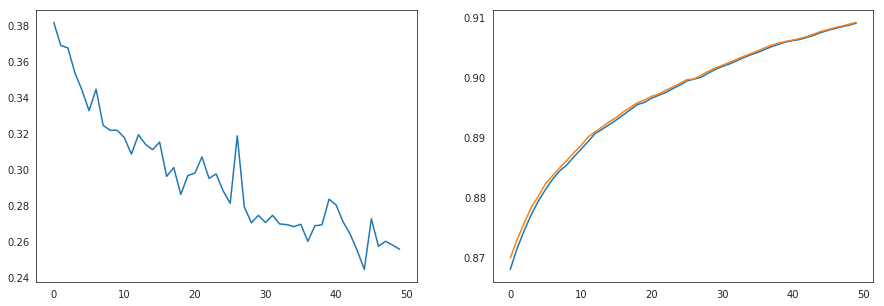

In [52]:
fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(15,5))
ax_loss.plot(results2.epoch, results2.history["loss"], label="Train loss")
#ax_loss.plot(results2.epoch, results2.history["val_loss"], label="Validation loss")
ax_acc.plot(results2.epoch, results2.history["mean_iou2"], label="Train accuracy")
ax_acc.plot(results2.epoch, results2.history["val_mean_iou2"], label="Validation accuracy")
fig.savefig('performance_plotb_'+str(version)+'.png')

In [53]:
model = load_model('model-tgs-salt-v7.h5',  custom_objects={'lovasz_loss':lovasz_loss,'mean_iou2':mean_iou2} )

In [54]:
predicted_validation = model.predict(x_val,verbose=1)#.reshape(-1,128,128)

800/800 [==============================] - 5s 6ms/step


In [55]:
predicted_validation = np.array([downscale(x) for x in predicted_validation])
ids_validation = np.array([train_df.loc[x].masks for x in ids_val])

## Model Predictions  <a name="ModelPredictions"></a>

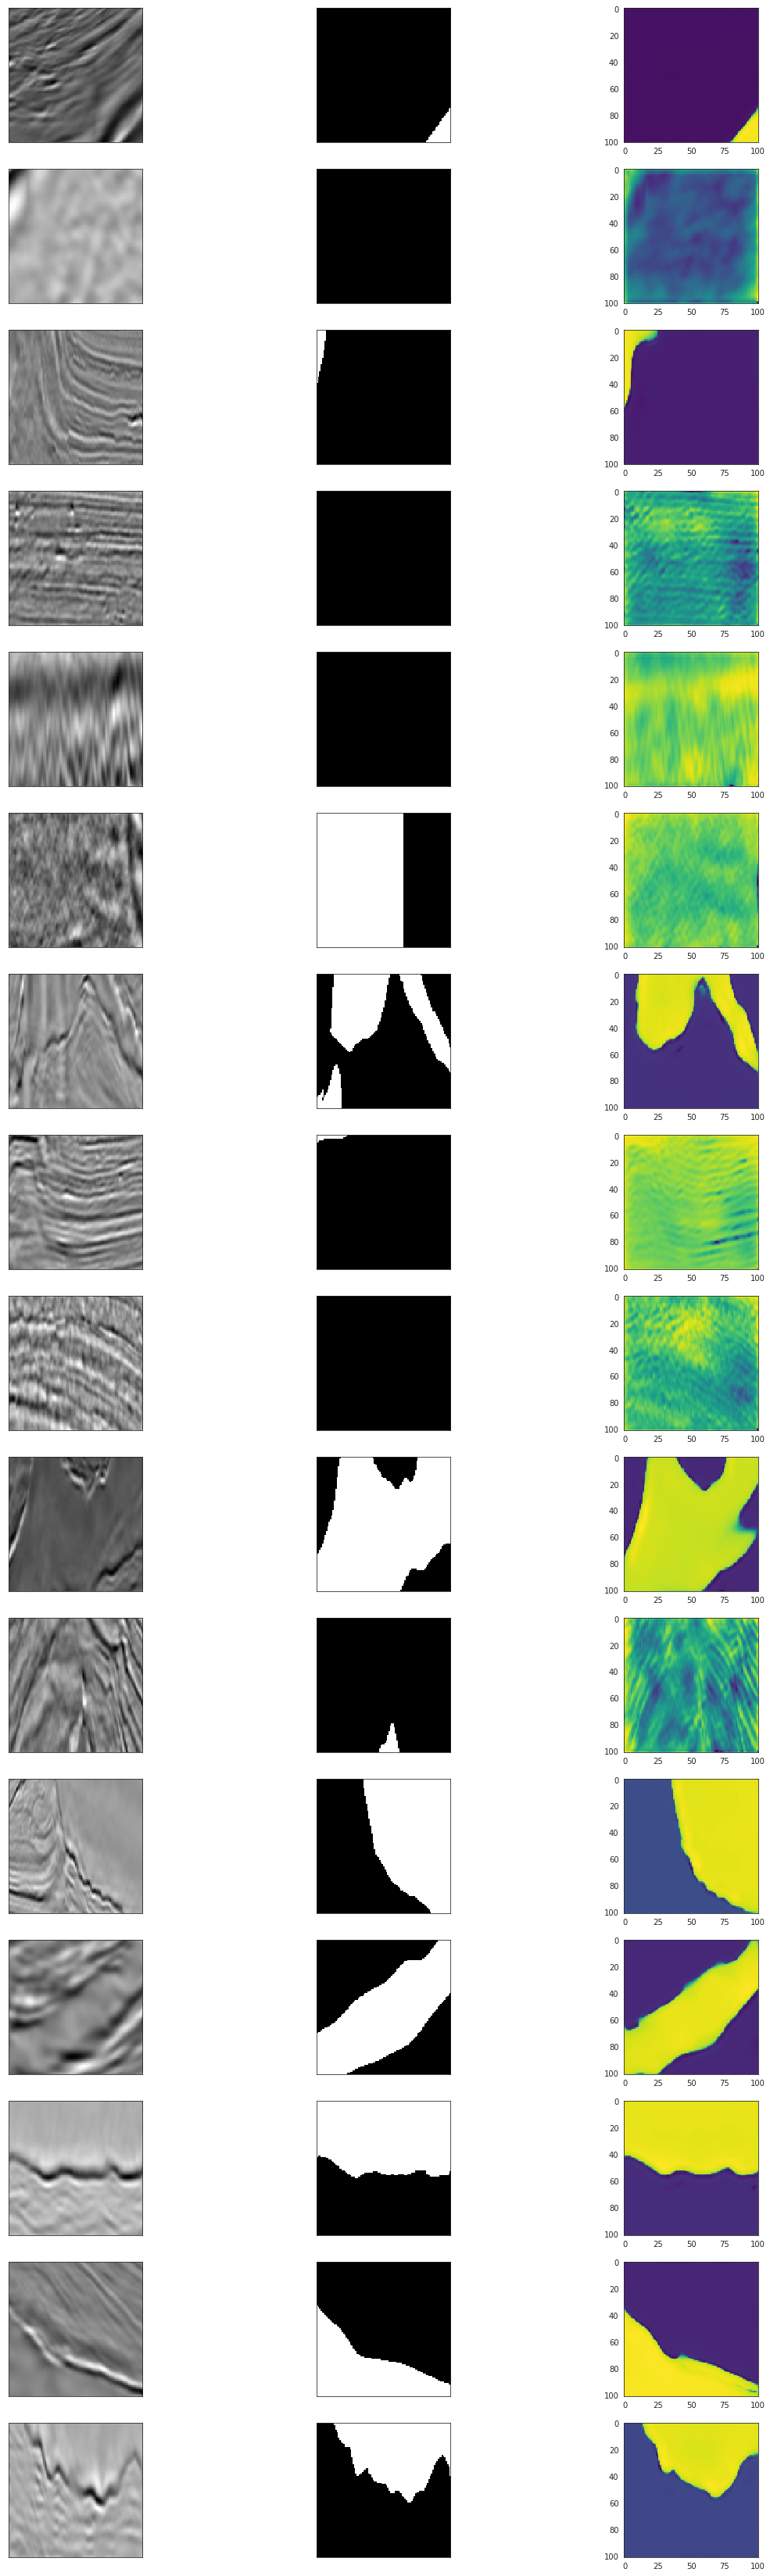

In [56]:
f, axarr = plt.subplots(16, 3, figsize=(20,60))

for i in range(16):
     
    j = np.random.randint(0,len(ids_validation))

    img = train_df.loc[ids_val[j]].images
    masks = train_df.loc[ids_val[j]].masks
    pred = predicted_validation[j][:,:,0]

    #print ids_val[j]
    
    axarr[i,0].imshow(img, cmap = 'gray')
    axarr[i,0].set_yticklabels([])
    axarr[i,0].set_xticklabels([])  
    axarr[i,1].imshow(masks, cmap = 'gray')
    axarr[i,1].set_yticklabels([])
    axarr[i,1].set_xticklabels([]) 
    axarr[i,2].imshow(pred, cmap = 'viridis',interpolation='none')
    #axarr[i,2].set_yticklabels([])
    #axarr[i,2].set_xticklabels([]) 

In [57]:
y_valid_ori = np.array([train_df.loc[idx].masks for idx in ids_val])
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in
    true_objects = 2
    pred_objects = 2

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    #print batch_size
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)

In [58]:
thresholds = np.linspace(0, 1, 50)
ious = np.array([iou_metric_batch(y_valid_ori, np.int32(predicted_validation > threshold)) for threshold in tqdm_notebook(thresholds)])

## Post Processing Model Results  <a name="PostProcessingModelResults"></a>

As this is an image segmenation problem each pixel is assigned a score which we can cut on to possibly improve the score. This is done by plotting the threshold value to cut on vs the IoU score. 

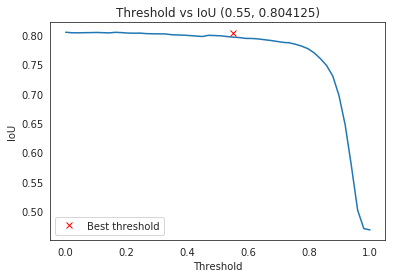

In [79]:
threshold_best_index = np.argmax(ious[9:-10]) + 9
iou_best = ious[threshold_best_index]
threshold_best = 0.55# thresholds[threshold_best_index]

plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()
plt.savefig("iou_threshold_"+str(version)+".png")

In [60]:
# Apply model to testing data to prepare for submission
x_test = np.array([upscale(np.array(load_img("/home/kuantumlad/Documents/projects/kaggle/kaggle-tgs_salt/input/test/images/{}.png".format(idx), color_mode="grayscale"))) for idx in tqdm_notebook(test_df.index)]).reshape(-1, 128, 128, 1)


In [61]:
print x_test.shape

(18000, 128, 128, 1)


# Predicting the Testing Data  <a name="PredictingtheTestingData"></a>
The model was used in predicting the testing data which was used for scoring. There are nontrivial features that the model picked up likely due to overtraining, as it has assigned a score of 0.5 to most of the region that isn't salt. This feature was seen above when looking at the training data. 

Post Processing Techniques
1. Gaussian Blur
2. Zero images with low predicted salt


Gaussian Blur: After producing the image's masks with the model, a Gaussian blur kernel was applied to the data to smoothen out the edges, and fill in gaps where salt should be but wasn't. This resulted in the score marginally improving. 

Zero Images: The IoU score was calculated for applying a cut on the minimum predicted salt in an image. It was favorable to set the entire predicted mask to zero if the image had less than 25 pixels of predicted salt. This decision was made because of the scoring system heavily penalized predicing any salt when the mask was blank.


In [62]:
#pred_model = load_model('model-tgs-salt_0825_1827.h5',  custom_objects={'bce_dice_loss':bce_dice_loss} )
pred_test = model.predict(x_test,verbose=1)

18000/18000 [==============================] - 85s 5ms/step


(18000, 128, 128, 1)
(18000, 128, 128, 1)


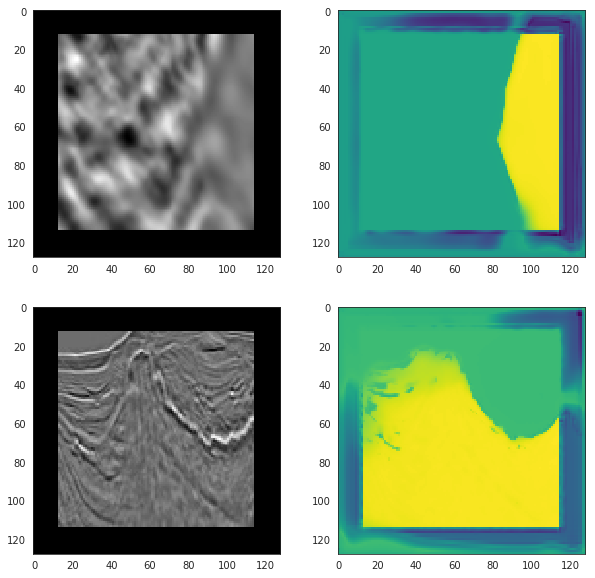

In [63]:
fig ,ax = plt.subplots(2,2,figsize=(10,10))
print pred_test.shape
test_pics = np.array([downscale(x) for x in pred_test])
print x_test.shape
ax[0,0].imshow(np.squeeze(x_test[579]),cmap='gray')
ax[0,1].imshow(np.squeeze(pred_test[579]),cmap='viridis')
ax[1,0].imshow(np.squeeze(x_test[2819]),cmap='gray')
ax[1,1].imshow(np.squeeze(pred_test[2819]),cmap='viridis')

### Score vs Salt Area Cut
Determine optimal value to set a salt area threshold cut to zero the entire predicted mask.

In [64]:
def iou_metric_batch_salt_area(y_true_in, y_pred_in, area_threshold):
    batch_size = y_true_in.shape[0]
    metric = []
    for i in range(batch_size):
                
        salt_area = np.sum(y_pred_in[i])
        #print salt_area
        y_pred_cut = y_pred_in[i]
        if salt_area < area_threshold:
            #print 'low salt'
            #print area_threshold
            y_pred_cut = np.zeros( (101,101,1), dtype=train_df.images.loc[ids_train[2]].dtype )
            
        value = iou_metric(y_true_in[i], y_pred_cut)
        #print value
        metric.append(value)
    return np.mean(metric)

#aggresively bin it
print threshold_best
area_thresholds = np.linspace(0,600, 50)
ious_salt_area = np.array([iou_metric_batch_salt_area(y_valid_ori, predicted_validation, area_threshold) for area_threshold in tqdm_notebook(area_thresholds)])

0.18367346938775508


(50,)
2


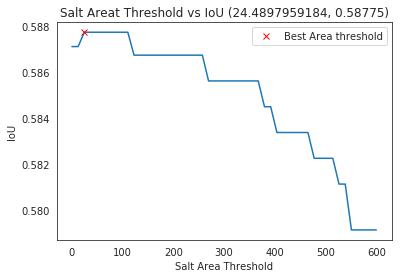

In [80]:
print ious_salt_area.shape
salt_area_threshold_best_index = np.argmax(ious_salt_area)
print salt_area_threshold_best_index
iou_best_salt_area = ious_salt_area[salt_area_threshold_best_index]
salt_threshold_best = area_thresholds[salt_area_threshold_best_index]

plt.plot(area_thresholds, ious_salt_area)
plt.plot(salt_threshold_best, iou_best_salt_area, "xr", label="Best Area threshold")
plt.xlabel("Salt Area Threshold")
plt.ylabel("IoU")
plt.title("Salt Areat Threshold vs IoU ({}, {})".format(salt_threshold_best, iou_best_salt_area))
plt.legend()
plt.savefig('salt_threshold_'+str(version)+'.png')

In [68]:
def RLenc(img, order='F', format=True):
    """
    img is binary mask image, shape (r,c)
    order is down-then-right, i.e. Fortran
    format determines if the order needs to be preformatted (according to submission rules) or not

    returns run length as an array or string (if format is True)
    """
    bytes = img.reshape(img.shape[0] * img.shape[1], order=order)
    runs = []  ## list of run lengths
    r = 0  ## the current run length
    pos = 1  ## count starts from 1 per WK
    for c in bytes:
        if (c == 0):
            if r != 0:
                runs.append((pos, r))
                pos += r
                r = 0
            pos += 1
        else:
            r += 1

    # if last run is unsaved (i.e. data ends with 1)
    if r != 0:
        runs.append((pos, r))
        pos += r
        r = 0

    if format:
        z = ''

        for rr in runs:
            z += '{} {} '.format(rr[0], rr[1])
        return z[:-1]
    else:
        return runs

In [69]:
#def filterGaus(temp_image):
 #   return cv2.GaussianBlur(temp_image,(7,7),0)

#pred_test2 = [ filterGaus(x) for x in pred_test ]

In [81]:

preds_test_t = (pred_test > threshold_best).astype(np.uint8)

predicted_final = [ downscale(x) for x in preds_test_t]

### Gaussian Blur
The two images below show the before and after applying gaussian blur kernel to the masks.

(101, 101, 1)


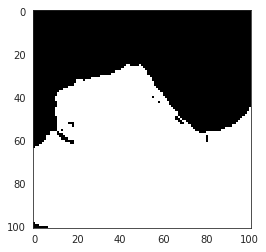

In [82]:
plt.imshow(predicted_final[2819].squeeze(), cmap='gray')
print predicted_final[2819].shape

In [83]:
def set_salt_area(img, salt_area_threshold):
    
    salt_area = np.sum(img)
    #print salt_area
    #print salt_area_threshold
    if salt_area < salt_area_threshold:
        #print 'here'
        z_test = np.zeros( (101,101,1) )#, dtype=train_df.images.loc[ids_train[2]].dtype )
        return z_test
    else:
        return img

In [84]:
predicted_final_salt_area_cut = [ set_salt_area(x,salt_threshold_best) for x in predicted_final]

In [85]:
def filterGaus(temp_image):
    return cv2.GaussianBlur(temp_image,(3,3),0)

predicted_final_gblur = [ filterGaus(x) for x in predicted_final ]

(101, 101)


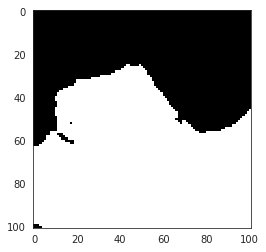

In [86]:
plt.imshow(predicted_final_gblur[2819].squeeze(), cmap='gray')
print predicted_final_gblur[2819].shape

# Prepare Submission  <a name="PrepareSubmission"></a>
Encode the masks with run length encoding to submit for scoring. 

In [87]:
#pred_dict = {idx: RLenc(np.round(downscale(pred_test[i]) > threshold_best)) for i, idx in enumerate(tqdm_notebook(test_df.index.values))}
pred_dict = {idx: RLenc(np.round(predicted_final_salt_area_cut[i])) for i, idx in enumerate(tqdm_notebook(test_df.index.values))}

In [88]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv('submissionv'+str(version)+'b.csv')

In [89]:
print x_val.shape
print x_test.shape
print predicted_final[0].shape

(800, 128, 128, 1)
(18000, 128, 128, 1)
(101, 101, 1)
